In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pylab as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit
reload(dit);

3


In [2]:
# Set up console so we can reattach via terminal ipython later. See:
# https://stackoverflow.com/questions/19479645/using-ipython-console-along-side-ipython-notebook

%qtconsole

# Then do `ipython console --existing` in a terminal to connect and have access to same data!
# But note, do not do CTRL-D in that terminal or it will kill the kernel!

Here I re-wrote `runTest` to use `afwTable.matchXy()` for catalog matching (instead of my own matching).
The resulting numbers are slightly different. The old values were:
    
```
{'ZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack': {'FP': 2, 'FN': 25, 'TP': 25}, 'SZOGY': {'FP': 4, 'FN': 24, 'TP': 26}, 'ALstack_decorr': {'FP': 5, 'FN': 25, 'TP': 25}}
```

In [3]:
reload(dit)
testObj = dit.diffimTests.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                        avoidAllOverlaps=15.)
res = testObj.runTest(returnSources=True, matchDist=np.sqrt(1.5))
src = res['sources']
del res['sources']
print res

{'ZOGY': {'FP': 3, 'FN': 11, 'TP': 39}, 'ALstack': {'FP': 1, 'FN': 11, 'TP': 39}, 'SZOGY': {'FP': 1, 'FN': 10, 'TP': 40}, 'ALstack_decorr': {'FP': 1, 'FN': 11, 'TP': 39}}


Do forced phot. now with funcs in diffimTests:

In [4]:
cats = testObj.doForcedPhot(transientsOnly=True)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats

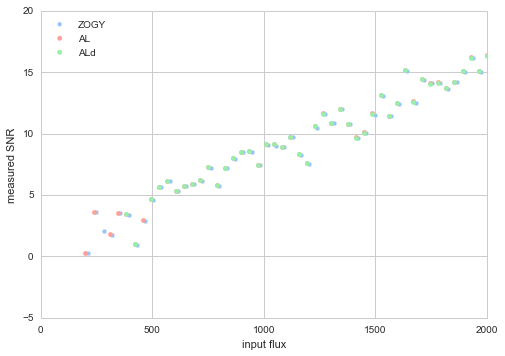

In [5]:
#%matplotlib notebook
plt.scatter(sources['inputFlux_science']+10, fp_ZOGY['base_PsfFlux_flux']/fp_ZOGY['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], fp_AL['base_PsfFlux_flux']/fp_AL['base_PsfFlux_fluxSigma'], label='AL', color='r')
plt.scatter(sources['inputFlux_science'], fp_ALd['base_PsfFlux_flux']/fp_ALd['base_PsfFlux_fluxSigma'], label='ALd', color='g')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')
plt.xlim(0, 2000);

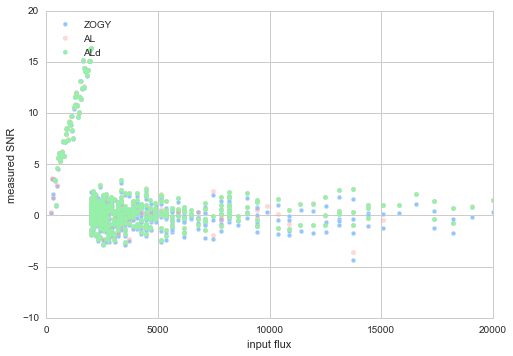

In [6]:
cats = testObj.doForcedPhot(transientsOnly=False)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats
#%matplotlib notebook
plt.scatter(sources['inputFlux_science']+10, fp_ZOGY['base_PsfFlux_flux']/fp_ZOGY['base_PsfFlux_fluxSigma'], label='ZOGY')
plt.scatter(sources['inputFlux_science'], fp_AL['base_PsfFlux_flux']/fp_AL['base_PsfFlux_fluxSigma'], label='AL', color='r', alpha=0.4)
plt.scatter(sources['inputFlux_science'], fp_ALd['base_PsfFlux_flux']/fp_ALd['base_PsfFlux_fluxSigma'], label='ALd', color='g')
plt.legend(loc='upper left')
plt.xlabel('input flux')
plt.ylabel('measured SNR')
plt.xlim(0, 20000);

Try to compute SNR directly using (a) source flux, (b) background variance, and (c) PSF...

0.997874609125


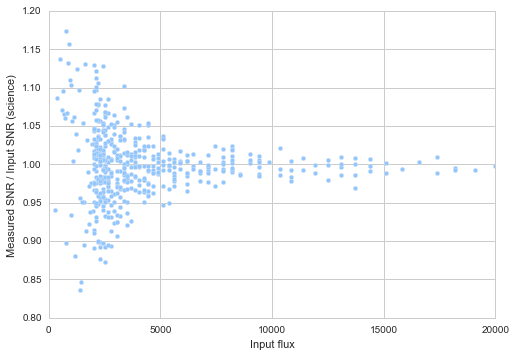

In [7]:
meas = fp2['base_PsfFlux_flux']/fp2['base_PsfFlux_fluxSigma']
calc = testObj.im2.calcSNR(sources['inputFlux_science'], skyLimited=True)
print np.median(meas/calc)
plt.scatter(sources['inputFlux_science'], meas/calc)
plt.xlim(0, 20000)
plt.ylim(0.8, 1.2);
plt.xlabel('Input flux')
plt.ylabel('Measured SNR / Input SNR (science)')

Figure out matching. Match sources detected in ZOGY diffim to input transients.

In [8]:
cats = testObj.doForcedPhot(transientsOnly=True)
sources, fp1, fp2, fp_ZOGY, fp_AL, fp_ALd = cats
dit.sizeme(dit.catalogToDF(sources).head())

,centroid_x,centroid_y,coord_dec,coord_ra,id,inputFlux_science,inputFlux_template,parent
0,197.457149,414.015301,0.927951,3.761644,1,1191.836735,0.0,0
1,152.201064,152.325854,0.928185,3.761575,2,1412.244898,0.0,0
2,439.876934,358.486998,0.927997,3.762004,3,567.346939,0.0,0
3,371.625483,217.622330,0.928124,3.761901,4,1595.918367,0.0,0
4,343.639653,133.832701,0.928199,3.761859,5,1338.775510,0.0,0


Cross-reference the *detections* in ZOGY (`src['ZOGY']`) with the input sources `sources` to identify which of the 50 input transients were detected.

Re-do with new `avoidAllOverlaps` option set to an avoidance radius of 5.

In [9]:
## Just re-create the testObj here:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=5.)

{'ZOGY': {'FP': 2, 'FN': 20, 'TP': 30}, 'ALstack': {'FP': 2, 'FN': 21, 'TP': 29}, 'SZOGY': {'FP': 3, 'FN': 21, 'TP': 29}, 'ALstack_decorr': {'FP': 2, 'FN': 21, 'TP': 29}}


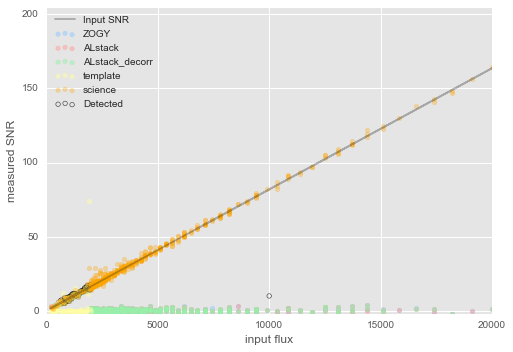

In [10]:
testObj.doPlotWithDetectionsHighlighted(transientsOnly=False, addPresub=True)
plt.xlim(0, 20010)
plt.ylim(-2, 205);

{'ZOGY': {'FP': 2, 'FN': 20, 'TP': 30}, 'ALstack': {'FP': 2, 'FN': 21, 'TP': 29}, 'SZOGY': {'FP': 3, 'FN': 21, 'TP': 29}, 'ALstack_decorr': {'FP': 2, 'FN': 21, 'TP': 29}}


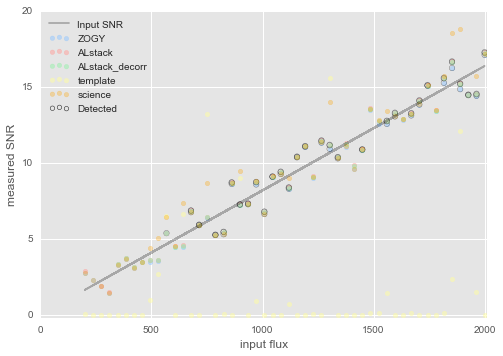

In [11]:
#%matplotlib notebook
df = testObj.doPlotWithDetectionsHighlighted(transientsOnly=True, addPresub=True)
plt.xlim(0, 2010)
plt.ylim(-0.2, 20);

Take a look at the apparently "anomalous" points... Well, using a radius of 15 got rid of all anomalous points! The below is what we would do if we used an exclusion radius of 5 instead...

In [12]:
tmp = df.ix[(df.scienceSNR > 12) & (df.scienceSNR < 15) & (df.inputFlux < 1500)]
dit.sizeme(tmp)

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_flux,ZOGY_fluxSigma,ZOGY_detected,ALstack_SNR,ALstack_flux,ALstack_fluxSigma,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_flux,ALstack_decorr_fluxSigma,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR
7,1485.714286,0.920029,1652.314241,8,346.777193,158.512358,13.447223,94.654817,7.038986,False,13.607483,1660.567701,122.033418,False,13.564097,1659.059131,122.312535,False,0.118561,13.542906,12.160626
13,1302.040816,130.578272,1708.020121,14,158.643498,144.278055,10.914438,76.992426,7.054181,True,11.182847,1367.542559,122.289301,True,11.150117,1366.651048,122.568319,True,15.591701,13.970065,10.657252


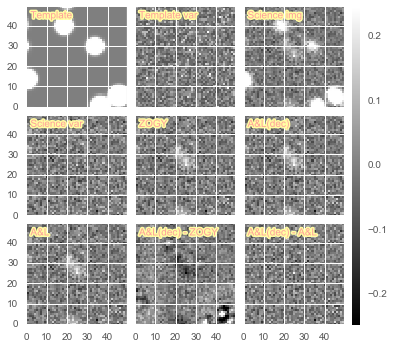

In [13]:
testObj.doPlot(centroidCoord=[tmp.inputCentroid_y.values[0], tmp.inputCentroid_x.values[0]]);

Re-do with new `avoidAllOverlaps` option set to an avoidance radius of 15. (That's big!)

In [14]:
## Just re-create the testObj here:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

{'ZOGY': {'FP': 3, 'FN': 11, 'TP': 39}, 'ALstack': {'FP': 1, 'FN': 11, 'TP': 39}, 'SZOGY': {'FP': 1, 'FN': 10, 'TP': 40}, 'ALstack_decorr': {'FP': 1, 'FN': 11, 'TP': 39}}


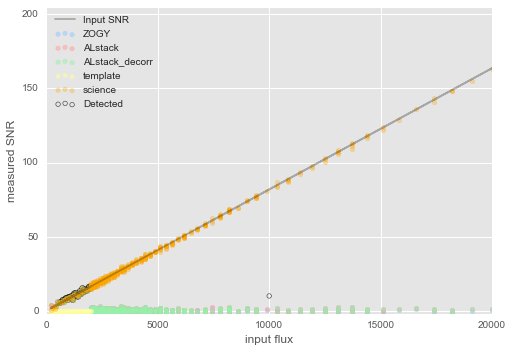

In [15]:
testObj.doPlotWithDetectionsHighlighted(transientsOnly=False, addPresub=True)
plt.xlim(0, 20010)
plt.ylim(-2, 205);

{'ZOGY': {'FP': 3, 'FN': 11, 'TP': 39}, 'ALstack': {'FP': 1, 'FN': 11, 'TP': 39}, 'SZOGY': {'FP': 1, 'FN': 10, 'TP': 40}, 'ALstack_decorr': {'FP': 1, 'FN': 11, 'TP': 39}}


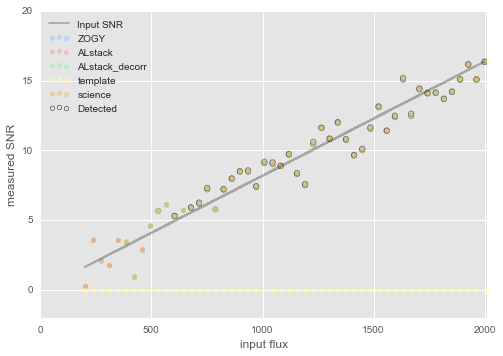

In [16]:
#%matplotlib notebook
df = testObj.doPlotWithDetectionsHighlighted(transientsOnly=True, addPresub=True)
plt.xlim(0, 2010)
plt.ylim(-2, 20);

Looks like `avoidAllOverlaps = 15` removes all anomalies. Yay!

Where are the ZOGY points? Are they there? I think they're all on top of the A&L points.

In [17]:
dit.sizeme(df.head())

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_flux,ZOGY_fluxSigma,ZOGY_detected,ALstack_SNR,ALstack_flux,ALstack_fluxSigma,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_flux,ALstack_decorr_fluxSigma,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR
0,1191.836735,1.016377e-07,907.030596,1,197.457149,414.015301,7.496908,52.194822,6.962180,True,7.593333,916.915023,120.752640,True,7.571247,916.385610,121.034971,True,1.390984e-08,7.512848,9.755173
1,1412.244898,5.712449e-06,1170.138568,2,152.201064,152.325854,9.633974,67.333265,6.989148,True,9.685084,1173.386434,121.153974,True,9.656463,1172.655835,121.437404,True,7.282887e-07,9.660393,11.559212
2,567.346939,8.013456e-09,752.702171,3,439.876934,358.486998,6.114537,43.314997,7.083937,False,6.132447,753.107270,122.806975,False,6.114724,752.690471,123.094766,False,9.749573e-10,6.130413,4.643730
3,1595.918367,1.664746e-05,1515.364168,4,371.625483,217.622330,12.378992,87.205581,7.044643,True,12.490211,1524.984125,122.094341,True,12.454773,1524.228625,122.381081,True,1.985758e-06,12.414184,13.062578
4,1338.775510,5.619036e-13,1477.943737,5,343.639653,133.832701,12.003994,85.056895,7.085717,True,12.021300,1478.121530,122.958539,True,11.987813,1477.464690,123.247225,True,8.937701e-14,12.021747,10.957866


(0.9, 1.02)

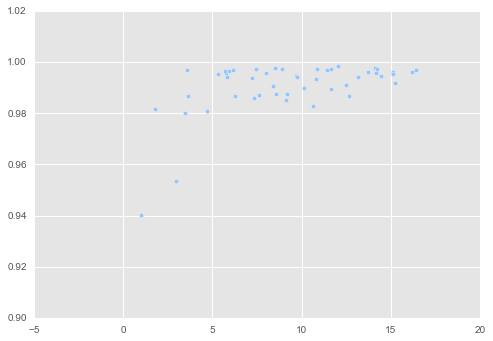

In [18]:
plt.scatter(df.ALstack_SNR, df.ZOGY_SNR / df.ALstack_SNR)
plt.ylim(0.90, 1.02)

{'ZOGY': {'FP': 3, 'FN': 11, 'TP': 39}, 'ALstack': {'FP': 1, 'FN': 11, 'TP': 39}, 'SZOGY': {'FP': 1, 'FN': 10, 'TP': 40}, 'ALstack_decorr': {'FP': 1, 'FN': 11, 'TP': 39}}


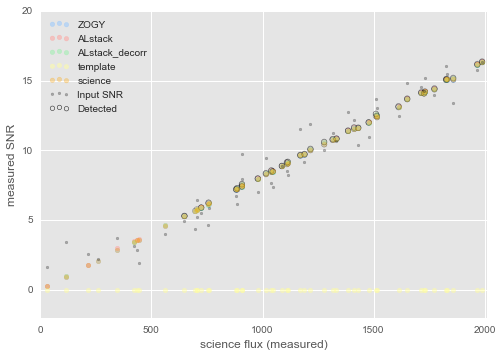

In [19]:
#%matplotlib notebook
testObj.doPlotWithDetectionsHighlighted(transientsOnly=True, addPresub=True,
                                        xaxisIsScienceForcedPhot=True)
plt.xlim(0, 2010)
plt.ylim(-2, 20);

Re-do with all ~5-sigma sources, and no static sources. Just for fun.

Actually, this would compltely *foobar* the AL results, so add a few static sources.
Looks like A&L fails often with `n_sources` below around 100.

That would be transient fluxes of ~610 if `templateNoNoise=True` or ~700 if it's `False`.

In [20]:
reload(dit)
testObj2 = dit.DiffimTest(n_sources=91, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.repeat(610., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

{'ZOGY': {'FP': 6, 'FN': 21, 'TP': 29}, 'ALstack': {'FP': 7, 'FN': 27, 'TP': 23}, 'SZOGY': {'FP': 10, 'FN': 26, 'TP': 24}, 'ALstack_decorr': {'FP': 6, 'FN': 29, 'TP': 21}}


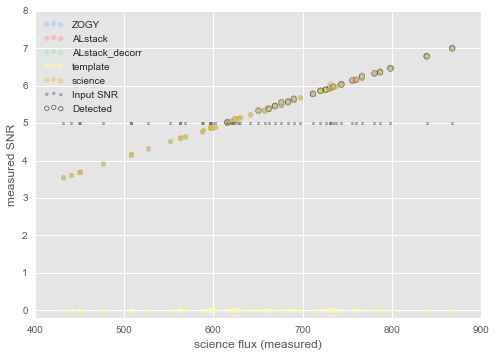

In [21]:
testObj2.doPlotWithDetectionsHighlighted(transientsOnly=True, addPresub=True,
                                         xaxisIsScienceForcedPhot=True)
plt.xlim(400, 900)
plt.ylim(-0.2, 8);

In [22]:
print testObj2.im1.sig, testObj2.im2.sig
print dit.computeClippedImageStats(testObj2.im1.var)
print dit.computeClippedImageStats(testObj2.im1.im)
print dit.computeClippedImageStats(testObj2.D_ZOGY.im)

1.4065451447 17.3171457546
(1.9783692440922556, 1.3730849706940382, 0.0, 11.0)
(0.75434670429246653, 12.827416416931918, 0.0, 1118.3127439668638)
(-0.00052481967161836058, 0.98833811807732785, -4.329280868029409, 5.2533795005431783)


Try it with `templateNoNoise=False` to see if `ALstack_decorr` works correctly in this case.

In [23]:
reload(dit)
testObj3 = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         templateNoNoise=False, skyLimited=False,
                         avoidAllOverlaps=15.)

{'ZOGY': {'FP': 4, 'FN': 16, 'TP': 34}, 'ALstack': {'FP': 2, 'FN': 15, 'TP': 35}, 'SZOGY': {'FP': 5, 'FN': 18, 'TP': 32}, 'ALstack_decorr': {'FP': 4, 'FN': 15, 'TP': 35}}


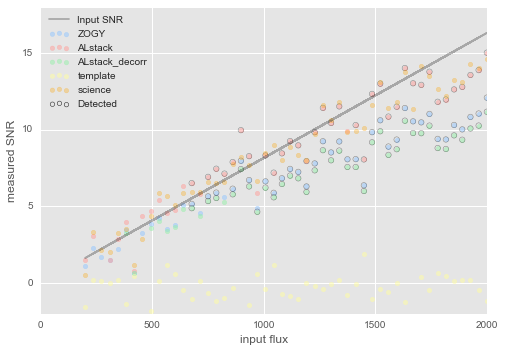

In [43]:
testObj3.doPlotWithDetectionsHighlighted(transientsOnly=True, addPresub=True,
                                         xaxisIsScienceForcedPhot=False)
plt.xlim(0, 2000)
plt.ylim(-2, 18);

The SNRs for `ZOGY` and `ALstack_decorr` above are correct, as they should be lower than the input science SNRs here -- because we DID have noise in the template.

### To be figured out: looks like `ALstack_decorr` diffim's have underestimated SNRs both when the template noise is nil, and when it is not!

This might simply be due to some rescaling that I am forcing on the decorrelated image.

Actually, it might be because the boundary pixels in the variance plane of the decorrelated image are getting set to `np.inf`. New code in `diffimTests.py` (lines 1835-1838) fixes this.

*But* it doesn't fix the underestimated SNRs for some reason (still TBD).

OK, I think it's because the decorrelated diffim PSF is incorrectly offset by one pixel. I will now fix it in `diffimTests.py` (line 1274) and test shows that it works!

First, let's look at sources that are detected in `ZOGY` but missed in `ALstack`.

{'ZOGY': {'FP': 3, 'FN': 11, 'TP': 39}, 'ALstack': {'FP': 1, 'FN': 11, 'TP': 39}, 'SZOGY': {'FP': 1, 'FN': 10, 'TP': 40}, 'ALstack_decorr': {'FP': 1, 'FN': 11, 'TP': 39}}


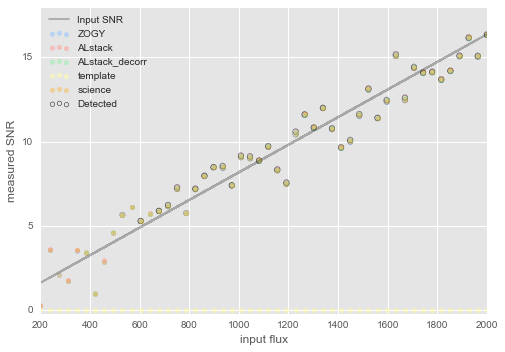

In [25]:
## Just re-create the testObj here:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(1000., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

df = testObj.doPlotWithDetectionsHighlighted(transientsOnly=True, 
                                             #xaxisIsScienceForcedPhot=True,
                                             addPresub=True)
plt.xlim(200, 2000)
plt.ylim(-0.2, 18);

In [26]:
dit.sizeme(df.head())

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_flux,ZOGY_fluxSigma,ZOGY_detected,ALstack_SNR,ALstack_flux,ALstack_fluxSigma,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_flux,ALstack_decorr_fluxSigma,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR
0,1191.836735,1.016377e-07,907.030596,1,197.457149,414.015301,7.496908,52.194822,6.962180,True,7.593333,916.915023,120.752640,True,7.571247,916.385610,121.034971,True,1.390984e-08,7.512848,9.755173
1,1412.244898,5.712449e-06,1170.138568,2,152.201064,152.325854,9.633974,67.333265,6.989148,True,9.685084,1173.386434,121.153974,True,9.656463,1172.655835,121.437404,True,7.282887e-07,9.660393,11.559212
2,567.346939,8.013456e-09,752.702171,3,439.876934,358.486998,6.114537,43.314997,7.083937,False,6.132447,753.107270,122.806975,False,6.114724,752.690471,123.094766,False,9.749573e-10,6.130413,4.643730
3,1595.918367,1.664746e-05,1515.364168,4,371.625483,217.622330,12.378992,87.205581,7.044643,True,12.490211,1524.984125,122.094341,True,12.454773,1524.228625,122.381081,True,1.985758e-06,12.414184,13.062578
4,1338.775510,5.619036e-13,1477.943737,5,343.639653,133.832701,12.003994,85.056895,7.085717,True,12.021300,1478.121530,122.958539,True,11.987813,1477.464690,123.247225,True,8.937701e-14,12.021747,10.957866


In [27]:
tmp = df.ix[(df.ZOGY_detected == False) & (df.ALstack_detected == True)]
dit.sizeme(tmp)

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_flux,ZOGY_fluxSigma,ZOGY_detected,ALstack_SNR,ALstack_flux,ALstack_fluxSigma,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_flux,ALstack_decorr_fluxSigma,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR


In [28]:
tmp = df.ix[(df.ZOGY_detected == True) & (df.ALstack_detected == False)]
dit.sizeme(tmp)

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_flux,ZOGY_fluxSigma,ZOGY_detected,ALstack_SNR,ALstack_flux,ALstack_fluxSigma,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_flux,ALstack_decorr_fluxSigma,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR
18,787.755102,3.783325e-07,703.683259,19,127.187588,99.976530,5.767783,40.494126,7.020744,True,5.802577,706.228090,121.709395,False,5.785885,705.842867,121.993943,False,4.566517e-08,5.782852,6.447769
30,530.612245,4.840344e-08,696.904041,31,420.281646,117.720497,5.660452,40.102006,7.084594,True,5.680081,697.882627,122.864903,False,5.663389,697.461004,123.152582,False,6.386049e-09,5.673180,4.343057


In [29]:
# Since detections are identical, let's just look at a transient missed by both methods: 
tmp = df.ix[(df.ZOGY_detected == False) & (df.ALstack_detected == False) &
           (df.templateFlux < 1.)]
dit.sizeme(tmp)

,inputFlux,templateFlux,scienceFlux,inputId,inputCentroid_x,inputCentroid_y,ZOGY_SNR,ZOGY_flux,ZOGY_fluxSigma,ZOGY_detected,ALstack_SNR,ALstack_flux,ALstack_fluxSigma,ALstack_detected,ALstack_decorr_SNR,ALstack_decorr_flux,ALstack_decorr_fluxSigma,ALstack_decorr_detected,templateSNR,scienceSNR,inputSNR
2,567.346939,8.013456e-09,752.702171,3,439.876934,358.486998,6.114537,43.314997,7.083937,False,6.132447,753.107270,122.806975,False,6.114724,752.690471,123.094766,False,9.749573e-10,6.130413,4.643730
13,420.408163,3.413358e-07,114.955900,14,396.791630,434.764335,0.949857,6.617318,6.966644,False,1.010234,122.075999,120.839306,False,1.007515,122.033060,121.122842,False,4.884973e-08,0.951484,3.441037
17,200.000000,5.808854e-07,30.134282,18,63.474273,467.895819,0.247298,1.724803,6.974598,False,0.293157,35.426593,120.845013,False,NaN,NaN,NaN,False,6.682202e-08,0.249424,1.636998
20,273.469388,8.702293e-10,257.082881,21,33.108662,146.609283,2.101444,14.793344,7.039609,False,NaN,NaN,NaN,False,NaN,NaN,NaN,False,1.225262e-10,2.105837,2.238345
24,493.877551,5.281779e-06,561.359288,25,452.612252,165.033540,4.581554,32.299535,7.049909,False,4.671114,570.791050,122.195914,False,4.656984,570.397247,122.482111,False,6.520391e-07,4.594977,4.042383
27,640.816327,3.879474e-09,703.798641,28,139.136507,82.251522,5.733973,40.500613,7.063272,False,5.759378,705.833840,122.553835,False,5.742989,705.479615,122.841878,False,6.097447e-10,5.743712,5.245076
28,346.938776,1.850437e-19,435.419824,29,337.832402,470.564744,3.542550,25.051530,7.071609,False,3.553343,435.420228,122.538186,False,NaN,NaN,NaN,False,2.196448e-20,3.554217,2.839691
29,383.673469,3.948137e-05,419.541326,30,399.740624,77.725656,3.406667,24.154998,7.090506,False,3.476137,427.395048,122.951150,False,3.468381,427.447049,123.241098,False,5.008927e-06,3.412913,3.140364
36,310.204082,2.134168e-07,214.208274,37,39.535497,162.996102,1.750943,12.337944,7.046456,False,1.783364,217.810938,122.134893,False,NaN,NaN,NaN,False,2.540959e-08,1.754246,2.539018
43,457.142857,1.031116e-05,346.389743,44,44.098702,304.466617,2.847506,19.912835,6.993079,False,2.986252,361.783697,121.149741,False,NaN,NaN,NaN,False,1.185406e-06,2.859912,3.741710


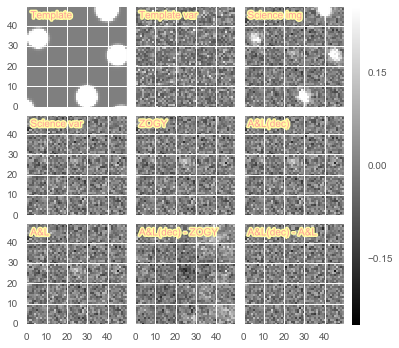

In [30]:
imagesToPlot, _ = testObj.doPlot(centroidCoord=[tmp.inputCentroid_y.values[0], 
                                  tmp.inputCentroid_x.values[0]]);

(6.5851998807978251, 32.618633753012006, 0.0, 476.71313886131566)
(1.9730815588589794, 1.3760851978905873, 0.0, 9.0)
(2.1407098121085597, 18.719571895178465, -56.0, 345.0)
(300.08065810593899, 17.602266969232744, 244.0, 357.0)
(0.017308988786734928, 1.0284032686819049, -3.415702604204145, 3.3450865212805847)
(0.59641486, 17.839506, -58.723484, 58.107613)
(0.59670836, 17.786203, -58.504456, 58.000095)
(-0.012558918028965289, 0.027595471618448053, -0.10491146244102278, 0.17672158494270285)
(-0.00014721404, 0.054734774, -0.21902847, 0.18339539)
(20, 20) (41, 41)
(20, 20) (41, 41)


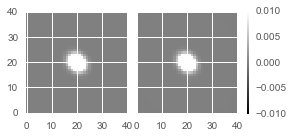

In [31]:
for img in imagesToPlot:
    print dit.computeClippedImageStats(img)
    
p1 = testObj.ALres.subtractedExposure.getPsf().computeImage().getArray()
p2 = testObj.ALres.decorrelatedDiffim.getPsf().computeImage().getArray()
#p2a = dit.fixEvenKernel(p2)
print np.unravel_index(np.argmax(p1), p1.shape), p1.shape
print np.unravel_index(np.argmax(p2), p2.shape), p2.shape
#print np.unravel_index(np.argmax(p2a), p2a.shape), p2a.shape

dit.plotImageGrid((p1, p2), clim=(-0.01, 0.01)) #,
                  #testObj.ALres.decorrelationKernel))

Plots to compare AL(d) vs. AL fluxes and SNRs...

0.997158613767


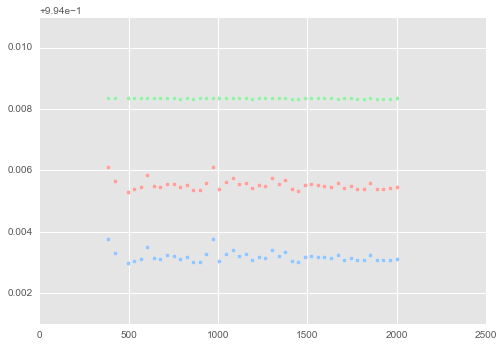

In [32]:
print (df.ALstack_decorr_SNR / df.ALstack_SNR).median()
plt.scatter(df.inputFlux, df.ALstack_decorr_flux / df.ALstack_flux, c='r')
plt.scatter(df.inputFlux, df.ALstack_decorr_fluxSigma / df.ALstack_fluxSigma, c='g')
plt.scatter(df.inputFlux, df.ALstack_decorr_SNR / df.ALstack_SNR, c='b')
plt.ylim(0.995, 1.005);

Plots to compare AL, AL(d) and ZOGY fluxes vs input flux.

(-0.05, 2.05)

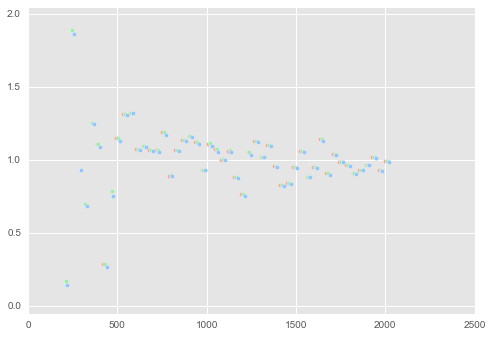

In [33]:
plt.scatter(df.inputFlux, df.ALstack_decorr_flux / df.inputFlux, c='r')
plt.scatter(df.inputFlux+10, df.ALstack_flux / df.inputFlux, c='g')
plt.scatter(df.inputFlux+20, df.ZOGY_flux / df.inputFlux * np.sqrt(300.), c='b')
plt.ylim(-0.05, 2.05)

In [34]:
img = testObj.ALres.decorrelatedDiffim.getMaskedImage().getImage().getArray()
img2 = testObj.ALres.subtractedExposure.getMaskedImage().getImage().getArray()
#dit.plotImageGrid((img, img2), imScale=8)

In [35]:
print dit.computeClippedImageStats(img)
print dit.computeClippedImageStats(img2)

(0.59303635, 17.479149, -77.554733, 115.20902)
(0.5405919, 17.394548, -77.307312, 115.01745)


207936
234256


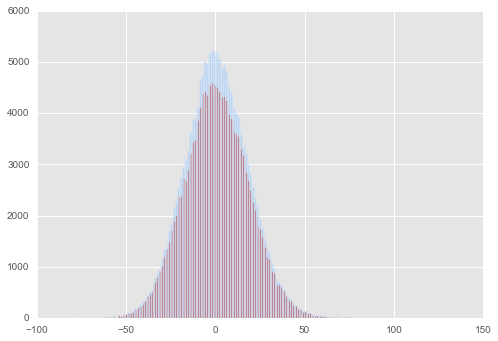

In [36]:
tmp = img.flatten()
print len(tmp[~np.isnan(tmp)])
plt.hist(tmp[~np.isnan(tmp)], bins=200);
tmp2 = img2.flatten()
print len(tmp2[(~np.isnan(tmp2))])
plt.hist(tmp2[(~np.isnan(tmp2))], bins=200, color='b', alpha=0.5);

In [37]:
img = testObj.ALres.decorrelatedDiffim.getMaskedImage().getVariance().getArray()
img2 = testObj.ALres.subtractedExposure.getMaskedImage().getVariance().getArray()
#dit.plotImageGrid((img, img2), imScale=8)

In [38]:
print dit.computeClippedImageStats(img)
print dit.computeClippedImageStats(img2)
# print img[0:80,80]

(301.88107, 17.18601, 219.42285, 376.4725)
(300.07751, 17.089945, 218.10541, 374.21228)


207936
234256


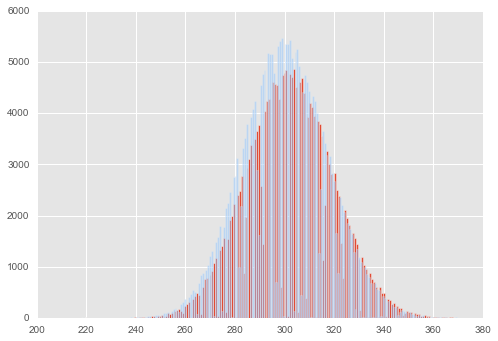

In [39]:
tmp = img.flatten()
print len(tmp[~np.isnan(tmp)])
plt.hist(tmp[~np.isnan(tmp)], bins=200);
tmp2 = img2.flatten()
print len(tmp2[(~np.isnan(tmp2)) & (np.isfinite(tmp2))])
plt.hist(tmp2[(~np.isnan(tmp2)) & (np.isfinite(tmp2))], bins=200, color='b', alpha=0.5);

## Try it with "realistic" noise in template:

{'ZOGY': {'FP': 4, 'FN': 16, 'TP': 34}, 'ALstack': {'FP': 2, 'FN': 15, 'TP': 35}, 'SZOGY': {'FP': 5, 'FN': 18, 'TP': 32}, 'ALstack_decorr': {'FP': 4, 'FN': 15, 'TP': 35}}


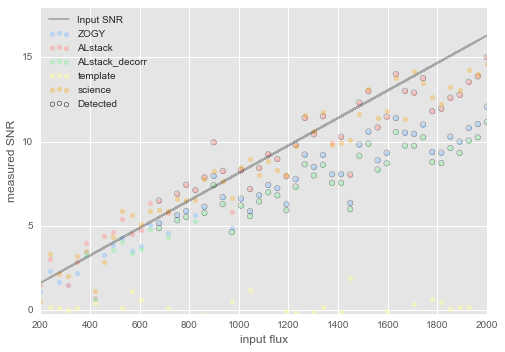

In [40]:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(1000., 50),
                         #templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

df = testObj.doPlotWithDetectionsHighlighted(transientsOnly=True, 
                                             #xaxisIsScienceForcedPhot=True,
                                             addPresub=True)
plt.xlim(200, 2000)
plt.ylim(-0.2, 18);

## And with a crowded field

{'ZOGY': {'FP': 0, 'FN': 24, 'TP': 26}, 'ALstack': {'FP': 1, 'FN': 25, 'TP': 25}, 'SZOGY': {'FP': 2, 'FN': 21, 'TP': 29}, 'ALstack_decorr': {'FP': 3, 'FN': 26, 'TP': 24}}


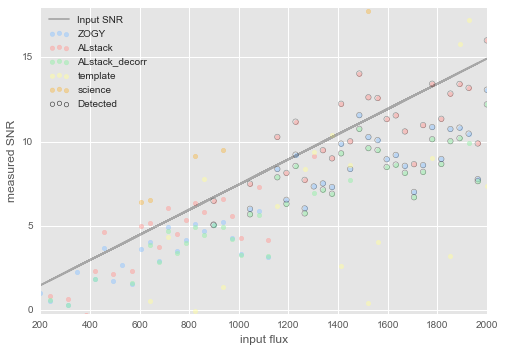

In [41]:
reload(dit)
testObj2 = dit.DiffimTest(n_sources=5000, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(1000., 50),
                         #templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

df = testObj2.doPlotWithDetectionsHighlighted(transientsOnly=True, 
                                             #xaxisIsScienceForcedPhot=True,
                                             addPresub=True)
plt.xlim(200, 2000)
plt.ylim(-0.2, 18);

## Understand why more sources were detected in ZOGY than A&L

in the case of noiseless template and sky-dominated noise. This is despite the fact that it seems that SNRs in all 3 diffims are basically identical.

Figured it out -- I set detection thresh for A&L to 5.5. Set it back to 5.0 and now it is all good...

{'ZOGY': {'FP': 3, 'FN': 11, 'TP': 39}, 'ALstack': {'FP': 1, 'FN': 11, 'TP': 39}, 'SZOGY': {'FP': 1, 'FN': 10, 'TP': 40}, 'ALstack_decorr': {'FP': 1, 'FN': 11, 'TP': 39}}


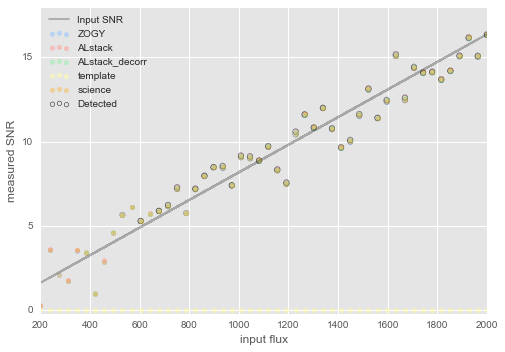

In [44]:
## Just re-create the testObj here:
reload(dit)
testObj = dit.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(1000., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

df = testObj.doPlotWithDetectionsHighlighted(transientsOnly=True, 
                                             #xaxisIsScienceForcedPhot=True,
                                             addPresub=True)
plt.xlim(200, 2000)
plt.ylim(-0.2, 18);